Running simulation with 1 layers...
Number of layers 1
Step 0 out of 20
Step 1 out of 20
Step 2 out of 20
Step 3 out of 20
Step 4 out of 20
Step 5 out of 20
Step 6 out of 20
Step 7 out of 20
Step 8 out of 20
Step 9 out of 20
Step 10 out of 20
Step 11 out of 20
Step 12 out of 20
Step 13 out of 20
Step 14 out of 20
Step 15 out of 20
Step 16 out of 20
Step 17 out of 20
Step 18 out of 20
Step 19 out of 20
Fidelities for 1 layers: [np.float64(1.0000000000000004), np.float64(0.9999988188435278), np.float64(0.9999648066010108), np.float64(0.9999478326487897), np.float64(0.9999993769548798), np.float64(0.9998283093134102), np.float64(0.9993492320467848), np.float64(0.9986909197948658), np.float64(0.9980055771846825), np.float64(0.9973898958284322), np.float64(0.9968836970560474), np.float64(0.9964905654446475), np.float64(0.9961967043773009), np.float64(0.9959827849831464), np.float64(0.9958299537671316), np.float64(0.9957222368119523), np.float64(0.9956470712413524), np.float64(0.995595011251

c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


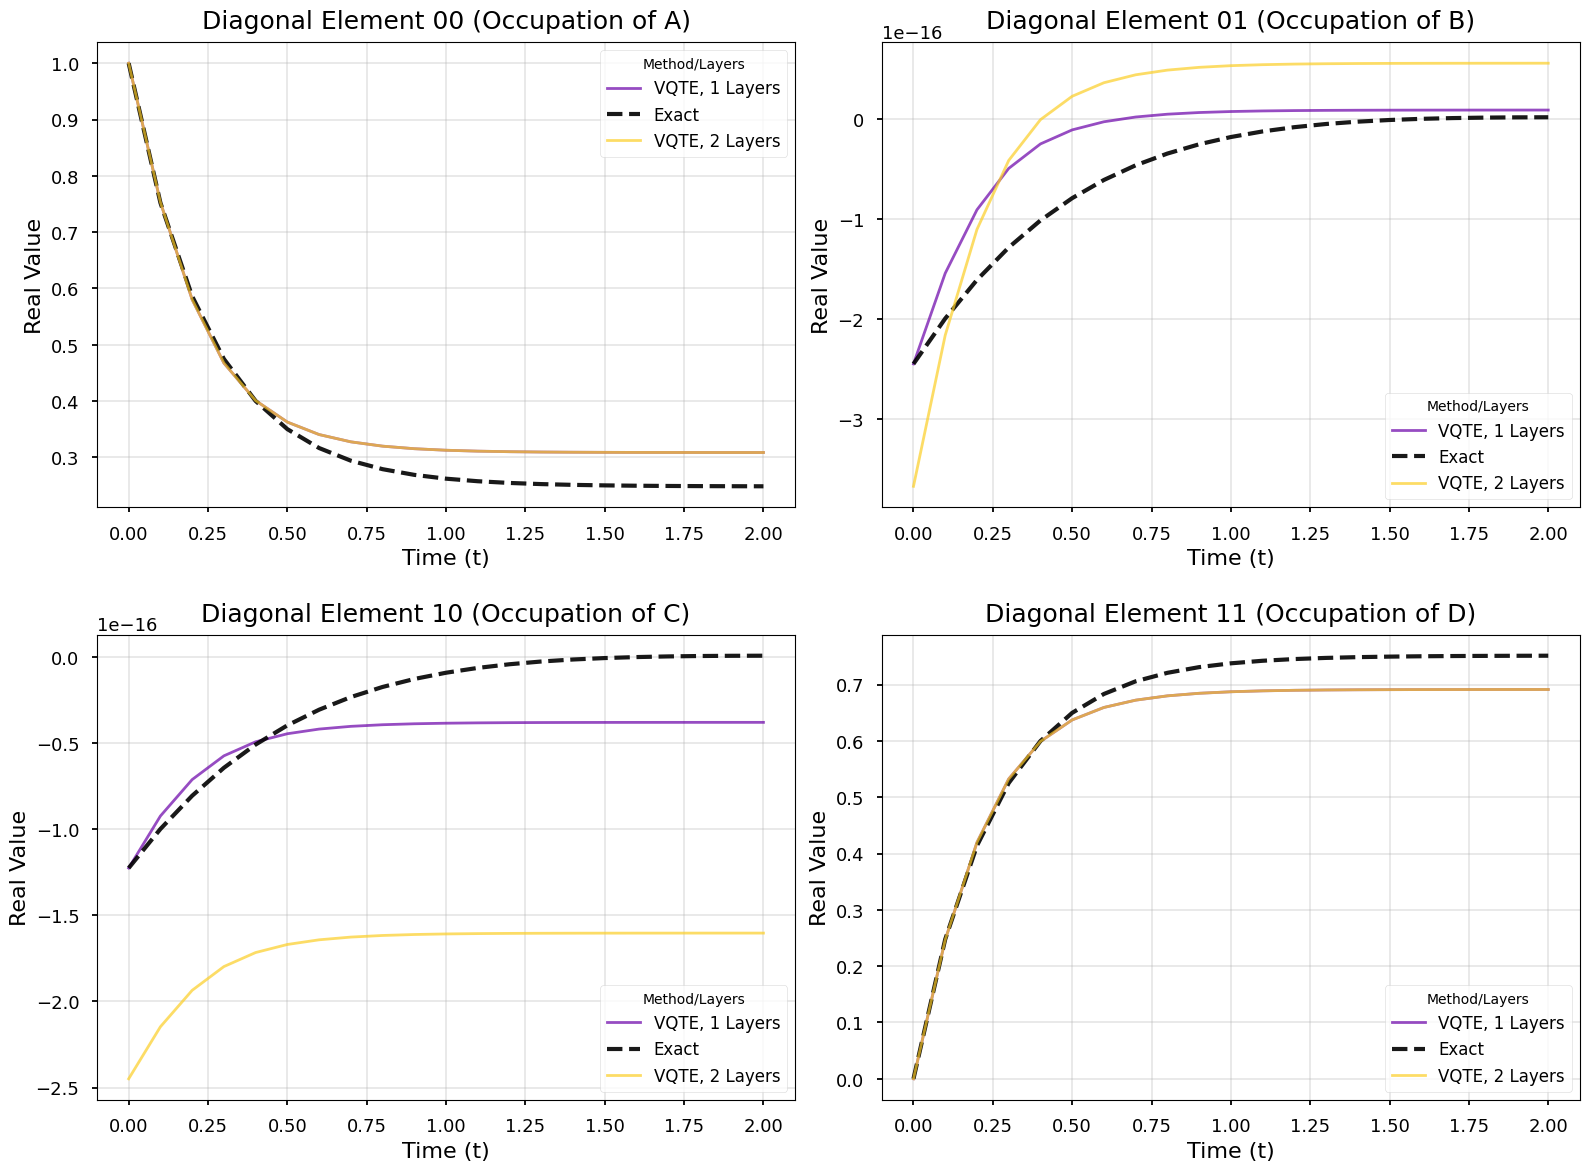

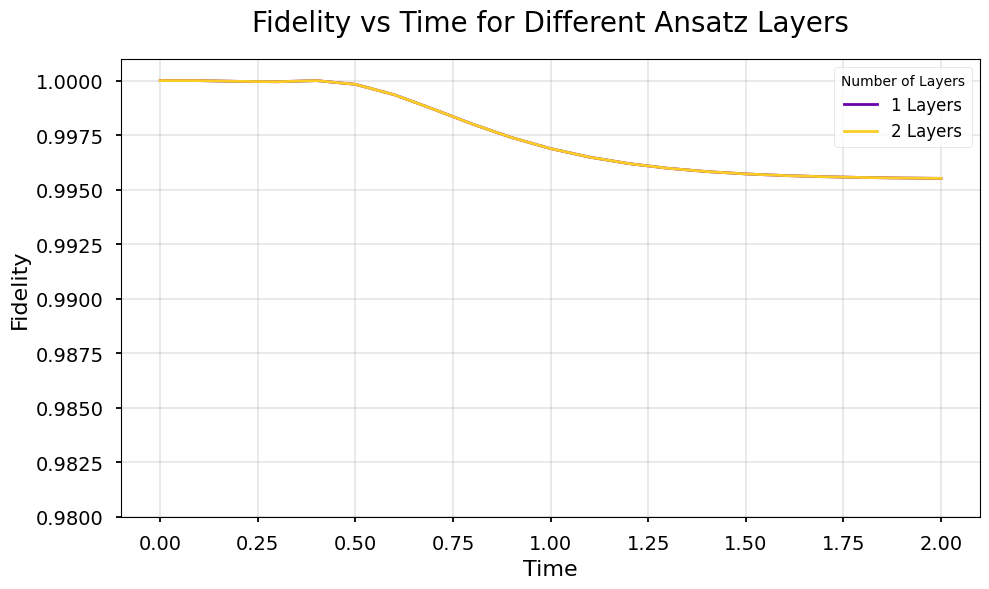

c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\transforms.py:2876: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


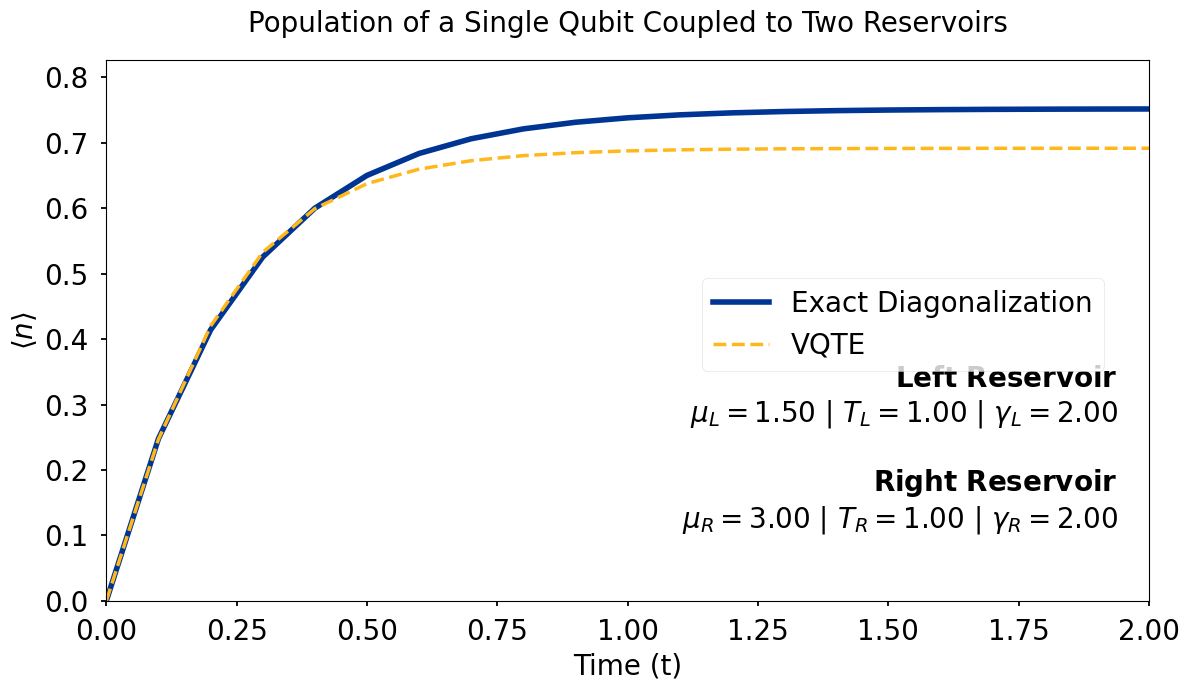

In [1]:
from fidelity_main import run_multiple_layers


def main():
    maxlayers=2
    time=2
    dt = 0.1
    run_multiple_layers(maxlayers,time,dt)

main()
